In [29]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [30]:
cTrain = np.loadtxt('Raw/train.csv')
cTrainLabel = np.loadtxt('Raw/trainLabel.csv').astype(int)
cTest = np.loadtxt('Raw/test.csv')
cTestlabel = np.loadtxt('Raw/testLabel.csv').astype(int)

In [31]:
p = int((len(cTrain)*0.8))

cTrain_p = cTrain[:p]
cVal = cTrain[p:]

cTrainLabels_p = cTrainLabel[:p]
cValLabels = cTrainLabel[p:]

print(len(cTrain_p), " ", len(cVal))

7144   1786


In [32]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.from_numpy(features).float()
        self.labels = torch.from_numpy(labels).long()
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        feature_vec = self.features[idx]
        label = self.labels[idx]
        return feature_vec, label

In [33]:
cTrain_dataloader = DataLoader(CustomDataset(cTrain_p, cTrainLabels_p), batch_size=32)
cVal_dataloader = DataLoader(CustomDataset(cVal, cValLabels), batch_size=32)
cTest_dataloader = DataLoader(CustomDataset(cTest, cTestlabel), batch_size=32)

In [34]:
class CNeuralNetwork(nn.Module):
    def __init__(self):
        super(CNeuralNetwork,self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(15, 15),
            nn.ReLU(),
            nn.Linear(15, 1),
            #nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        prediction = self.model(x)
        return prediction

In [35]:
cModel = CNeuralNetwork()
print(cModel)

CNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=15, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=1, bias=True)
  )
)


In [36]:
def cTraining(dataloader, model, loss_fn, optimizer):
    full_loss = 0
    correct = 0
    
    for (X, y) in dataloader:
        
        pred = model(X)
        yf = y.type(torch.FloatTensor)
        loss = loss_fn(pred, yf.unsqueeze(1)) 
        full_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        correct += (torch.flatten((pred > 0).long()) == y).type(torch.float).sum().item()
    
    full_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print("Training Loss ", full_loss)
    print("Training Accuracy ", correct)
    return full_loss, correct

In [37]:
def cTesting(dataloader, model, loss_fn):
    test_loss = 0
    correct = 0
    predLabels = []
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            yf = y.type(torch.FloatTensor)
            test_loss += loss_fn(pred, yf.unsqueeze(1)).item()
            correct += (torch.flatten((pred > 0).long()) == y).type(torch.float).sum().item()
            predLabels.append(torch.flatten((pred > 0).long()).tolist())
    
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print("Testing loss ", test_loss)
    print("Testing Accuracy ", correct)
    predLabels = list(np.concatenate(predLabels).flat)
    return test_loss, correct, predLabels

In [38]:
cModel = CNeuralNetwork()
cLoss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss
cOptimizer = torch.optim.Adam(cModel.parameters())

cTrainingAcc = []
cTrainingLoss = []
cValidationAcc = []
cValidationLoss = []

for e in range(50):
    print("Epoch ", e+1, "\n-----------------------------------")
    cTLoss, cTAcc = cTraining(cTrain_dataloader, cModel, cLoss_fn, cOptimizer)
    cTrainingAcc.append(cTAcc)
    cTrainingLoss.append(cTLoss)
    cVLoss, cVAcc, x = cTesting(cVal_dataloader, cModel, cLoss_fn)
    cValidationAcc.append(cVAcc)
    cValidationLoss.append(cVLoss)
    print()
x, y, cPredLabels = cTesting(cTest_dataloader, cModel, cLoss_fn)

Epoch  1 
-----------------------------------
Training Loss  0.6747906631124871
Training Accuracy  0.6023236282194849
Testing loss  0.6477361534323011
Testing Accuracy  0.6377379619260918

Epoch  2 
-----------------------------------
Training Loss  0.6205821210252387
Training Accuracy  0.6683930571108623
Testing loss  0.6090570400868144
Testing Accuracy  0.6511758118701008

Epoch  3 
-----------------------------------
Training Loss  0.5846178777781981
Training Accuracy  0.7026875699888018
Testing loss  0.5740391106477806
Testing Accuracy  0.7043673012318029

Epoch  4 
-----------------------------------
Training Loss  0.5502196686076266
Training Accuracy  0.7374020156774916
Testing loss  0.5405157219086375
Testing Accuracy  0.7379619260918253

Epoch  5 
-----------------------------------
Training Loss  0.5220845849918467
Training Accuracy  0.7625979843225084
Testing loss  0.5158178337982723
Testing Accuracy  0.7597984322508399

Epoch  6 
-----------------------------------
Training 

Training Loss  0.4369854668288359
Training Accuracy  0.8012318029115342
Testing loss  0.45076749633465496
Testing Accuracy  0.7961926091825308

Epoch  45 
-----------------------------------
Training Loss  0.4366504718948688
Training Accuracy  0.801511758118701
Testing loss  0.45062499599797384
Testing Accuracy  0.7961926091825308

Epoch  46 
-----------------------------------
Training Loss  0.4363401163635509
Training Accuracy  0.8013717805151176
Testing loss  0.4504873789846897
Testing Accuracy  0.7950727883538634

Epoch  47 
-----------------------------------
Training Loss  0.4360483504964837
Training Accuracy  0.8020716685330347
Testing loss  0.4502919263073376
Testing Accuracy  0.7945128779395296

Epoch  48 
-----------------------------------
Training Loss  0.43575707177764605
Training Accuracy  0.8027715565509519
Testing loss  0.4500880906624453
Testing Accuracy  0.7945128779395296

Epoch  49 
-----------------------------------
Training Loss  0.43550723298851934
Training Accu

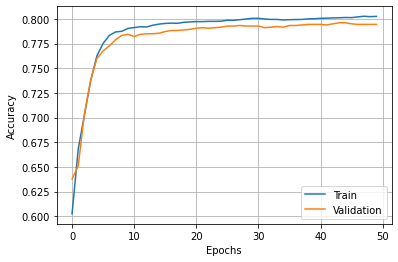

In [39]:
plt.plot(cTrainingAcc)
plt.plot(cValidationAcc)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])

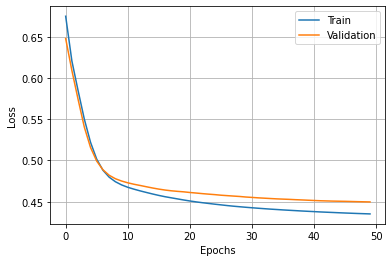

In [40]:
plt.plot(cTrainingLoss)
plt.plot(cValidationLoss)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Validation'])

In [41]:
print(classification_report(cTestlabel, cPredLabels))

              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1182
           1       0.76      0.81      0.79      1050

    accuracy                           0.79      2232
   macro avg       0.79      0.79      0.79      2232
weighted avg       0.79      0.79      0.79      2232



Text(33.0, 0.5, 'Truth')

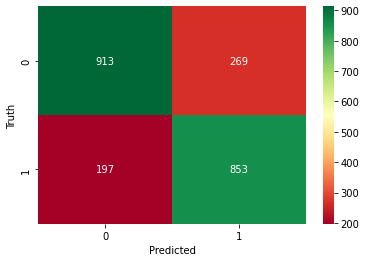

In [42]:
cConf_mat = confusion_matrix(cTestlabel, cPredLabels)

sn.heatmap(cConf_mat, annot=True, cmap='RdYlGn', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')